# Model A

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [2]:
r1 = h5py.File('./outputN32dt0001FEH0_01.h5','r') 
r2 = h5py.File('./outputN16dt0001FE1Core.h5','r') # this is actually 32
r3 = h5py.File('./outputN32dt001BEH0_01.h5','r') 
r4 = h5py.File('./outputN32dt0001BEBisH0_01.h5','r') 
r5 = h5py.File('./outputN32dt0002FEH0_01.h5','r') 
r6 = h5py.File('./outputN32dt0005FEH0_01.h5','r') 
r7 = h5py.File('./outputN32dt001FEH0_01.h5','r') 
r8 = h5py.File('./outputN32dt0005BEH0_01.h5','r') 

print(list(r1.keys()))
phi=np.asarray(r1["phi"])
x = np.loadtxt("/Users/adrien/Documents/langevin/bin/averages.txt") #FE n=32 dt=0.001

['phi', 'phidot', 'wallX_phi_0', 'wallX_phi_1', 'wallX_phi_2', 'wallX_phi_3', 'wallX_phi_4', 'wallX_phidot_0', 'wallX_phidot_1', 'wallX_phidot_2', 'wallX_phidot_3', 'wallX_phidot_4']


In [21]:
def autocorrelationfunction(arr, tMax):
    mean = np.mean(arr)
    gamma = np.zeros(tMax)
    for t in range(tMax):
        for tt in range(tMax-t):
            gamma[t]+=(arr[t]-mean)*(arr[t+tt]-mean)
        gamma[t]/=float(tMax-t)
        
    return gamma

In [37]:
res=autocorrelationfunction(r1["phi"][6000:-1:1,0],10000)

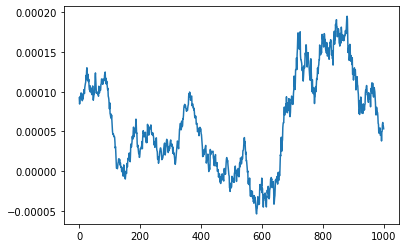

In [36]:
plt.plot(res[:])

In [2]:
crazy = h5py.File('./superCrazyyyy.h5','r') 
x = h5py.File('./crazy.h5','r') 


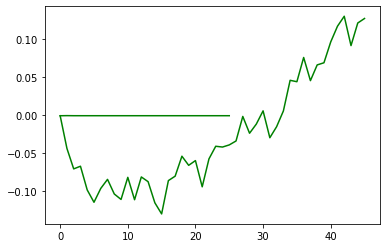

In [3]:
plt.plot(crazy["phi"][0:-1:1,0],'g')
plt.plot(x["phi"][0:-1:1,0],'g')


In [5]:
np.mean(r4["phi"][6000:-1:10,0])

0.3014811023447969

In [17]:
np.mean(x[1000:,1])

0.29429933333333336

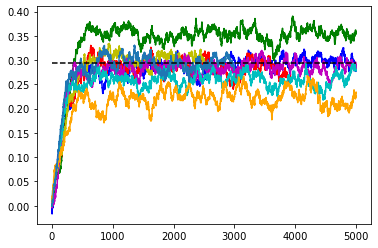

In [8]:
plt.plot(r1["phi"][0:-1:10,0],'b')
plt.plot(r2["phi"][0:-1:1,0],'r')
plt.plot(r3["phi"][0:-1:10,0],'g')
plt.plot(r4["phi"][0:-1:10,0],'y')
plt.plot(r5["phi"][0:-1:10,0],'m')
plt.plot(r6["phi"][0:-1:10,0],'c')
plt.plot(r7["phi"][0:-1:10,0],'orange')
plt.plot(x[:,1])
#plt.ylim([2,2.5])


plt.plot([0,5000],[0.295,0.295],'k--')


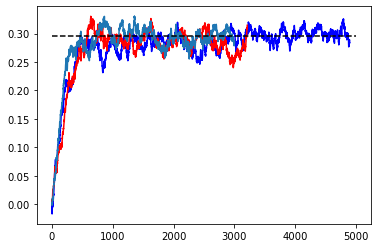

In [23]:
plt.plot(r1["phi"][0:-1:10,0],'b')
plt.plot(r2["phi"][0:-1:1,0],'r')

plt.plot(x[:,1])
#plt.ylim([2,2.5])


plt.plot([0,5000],[0.295,0.295],'k--')

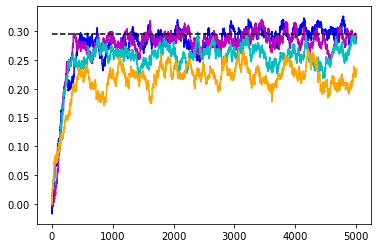

In [24]:
plt.plot(r1["phi"][0:-1:10,0],'b')

plt.plot(r5["phi"][0:-1:10,0],'m')
plt.plot(r6["phi"][0:-1:10,0],'c')
plt.plot(r7["phi"][0:-1:10,0],'orange')
#plt.ylim([2,2.5])


plt.plot([0,5000],[0.295,0.295],'k--')


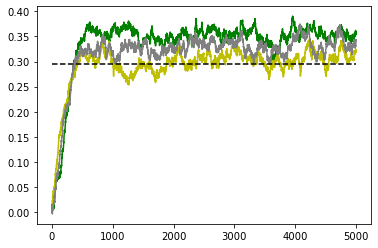

In [10]:
plt.plot(r3["phi"][0:-1:10,0],'g')
plt.plot(r4["phi"][0:-1:10,0],'y')
plt.plot(r8["phi"][0:-1:10,0],'gray')
plt.plot([0,5000],[0.295,0.295],'k--')

In [83]:
testManu = res.manualFourier(res.wallXphiNorm[2])
testauto = np.fft.fft(res.wallXphiNorm[2])
print(testManu)
print(testauto)

[ 2.56160799e+01+0.00000000e+00j -8.86368577e-02-6.12267668e-02j
  9.25191244e-02-3.04928488e-02j  1.01719903e-01+6.17417601e-03j
 -1.54372650e-01+1.45564770e-01j -4.23818508e-02+3.65530791e-02j
 -1.68795429e-01-2.42254753e-02j  9.40541357e-03+7.28437315e-02j
 -6.18189194e-02-7.80445642e-15j  9.40541357e-03-7.28437315e-02j
 -1.68795429e-01+2.42254753e-02j -4.23818508e-02-3.65530791e-02j
 -1.54372650e-01-1.45564770e-01j  1.01719903e-01-6.17417601e-03j
  9.25191244e-02+3.04928488e-02j -8.86368577e-02+6.12267668e-02j]
[ 2.56160799e+01+0.j         -8.86368577e-02-0.06122677j
  9.25191244e-02-0.03049285j  1.01719903e-01+0.00617418j
 -1.54372650e-01+0.14556477j -4.23818508e-02+0.03655308j
 -1.68795429e-01-0.02422548j  9.40541357e-03+0.07284373j
 -6.18189194e-02+0.j          9.40541357e-03-0.07284373j
 -1.68795429e-01+0.02422548j -4.23818508e-02-0.03655308j
 -1.54372650e-01-0.14556477j  1.01719903e-01-0.00617418j
  9.25191244e-02+0.03049285j -8.86368577e-02+0.06122677j]


In [48]:
res = EnsembleResults('./data/N16_tests/seaw/run40n', 18,14)
res.corFourierPhi(200,10,10)


./N16_tests/seaw/run40n_14.h5
9801
./N16_tests/seaw/run40n_15.h5
9801
./N16_tests/seaw/run40n_16.h5
9801
./N16_tests/seaw/run40n_17.h5
9801
./N16_tests/seaw/run40n_18.h5
9801


In [191]:
lRes = []
lResErr = []

for i in range(1):
    res = ConfResults('./data/N32/outputN32dt0005H0_01.h5',40000,100)
    res.computeMag(i)
    lRes.append(res.mag)
    lResErr.append(res.magErr)
    


In [192]:
lResErr

[5.249556804618974e-05]

In [177]:
20000*0.005

100.0

In [198]:
fns=["outputN32dt00003H0_01", "outputN32dt0001H0_01", "outputN32dt0005H0_01", "outputN32dt001H0_01", "outputN32dt005H0_01"]

resMag=[]
resMagErr=[]
dts = [0.0003, 0.001, 0.005, 0.01, 0.05]

for i  in range(len(fns)):
    res = ConfResults("./data/N32/"+fns[i]+".h5",20000,10)
    res.computeMag(0)
    res.computePhiDot(0)
    resMag.append(res.mag)
    resMagErr.append(res.magErr)

In [199]:
resMag

[0.32812981295029203,
 0.3260695351863463,
 0.3296509470948854,
 0.35448547740974357,
 0.5183050415226178]

In [98]:
fns=["outputN32dt0001H0_001", "outputN32dt0005H0_001", "outputN32H0_001"]

resMag=[]
resMagErr=[]
dts = [0.001, 0.005, 0.01]

for fn in fns:
    res = ConfResults("./data/N32/"+fn+".h5",20000,10)
    res.computeMag(0)
    res.computePhiDot(0)
    resMag.append(res.mag)
    resMagErr.append(res.magErr)

In [61]:
tmp.reverse()

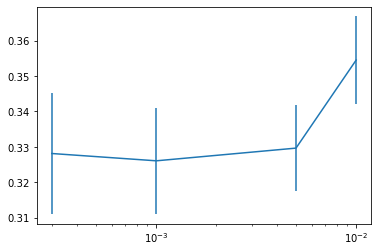

In [200]:
plt.errorbar(dts[:-1], resMag[:-1],resMagErr[:-1])
plt.xscale('log')

In [202]:
res = ConfResults('./data/N32/outputN32dt0005H0_01.h5', 20000,10)

In [207]:
res.wallXFourier0()
test=res.computeCttp(np.conj(res.wallXphi0F[:,1]),res.wallXphi0F[:,1])

In [190]:
mean, err = bootstrap(res.corrTot,5)

In [152]:
np.shape(mean)

(16, 301)

In [113]:
res.wallXFourier()

In [116]:
test=res.computeCttp(np.conj(res.wallXphiNormF[:,1]),res.wallXphiNormF[:,1])

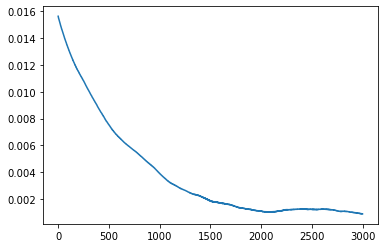

In [214]:
plt.plot(np.real(test)[:3000])

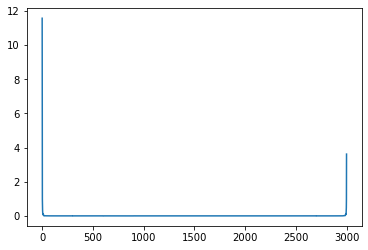

In [220]:
plt.plot(np.real(np.fft.fft(np.real(test)[:3000])))

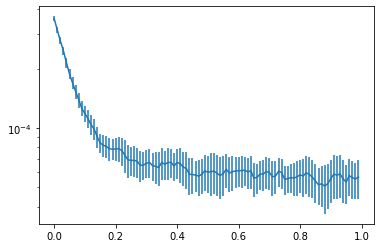

In [33]:
end=100
dt = 0.01
t = np.arange(len(res.corFourierPhiMean[1][0:end])) * dt
plt.errorbar(t,np.real(res.corFourierPhiMean[1][0:end]),np.real(res.corFourierPhiErr[1][0:end]))
plt.yscale('log')

In [61]:
fft[:int(len(fft)/2)]
np.asarray(fft[int(len(fft)/2+1):]).flip()

AttributeError: 'numpy.ndarray' object has no attribute 'flip'

In [52]:
fft=np.fft.fft(res.corFourierPhiMean[4][0:100])
fft=np.concatenate(fft[:int(len(fft)/2)],fft[-1:int(len(fft)/2+1)])

TypeError: only integer scalar arrays can be converted to a scalar index

In [32]:
print(res.wallXphi[0][0])
print(res.wallXphi[1][0])
print(res.wallXphi[2][0])
print(res.wallXphi[3][0])

[ 0.03980615  0.00921391  0.00448425 -0.00629541  0.13847117  0.18007944
  0.18124877  0.25109351  0.27025765  0.22871868  0.28205302  0.18860907
  0.0910679   0.11848171  0.03691116  0.03114464]
[0.06629917 0.13449335 0.22304684 0.33576112 0.3886682  0.38745133
 0.39043144 0.32277384 0.20377822 0.18944155 0.22025963 0.20037172
 0.20758677 0.17045621 0.1095648  0.15142416]
[-1.97070256 -1.96663464 -1.95699276 -1.92538197 -1.93809525 -2.05809571
 -2.00253098 -2.02835163 -2.04785177 -2.06632884 -2.12208639 -2.15115059
 -2.09956571 -2.02178736 -1.96218925 -1.99521995]
[-1.81456117 -1.79362135 -1.76388443 -1.82248324 -1.82312704 -1.69377328
 -1.71348992 -1.68470556 -1.72449619 -1.66984524 -1.5642932  -1.56867645
 -1.65756129 -1.74702555 -1.80289948 -1.74809884]


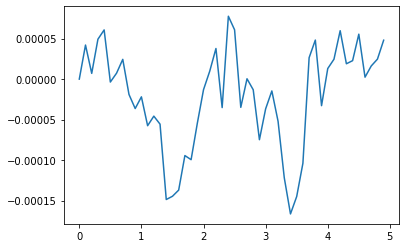

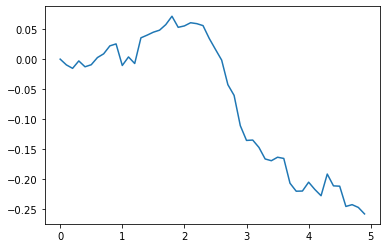

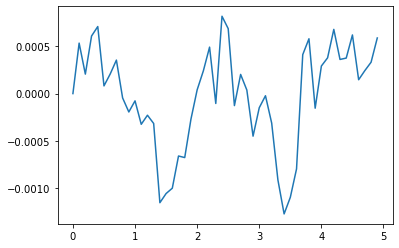

In [42]:
res = Results('./N16_tests/outputN16_1.h5',200)
res.computeCttpPhi()
res.computeCttpPhidot()
res.computeCttpPhiPhidot()

end =50
dt = 0.1
t = np.arange(len(res.CttpPhi[:end])) * dt
plt.figure(0)
plt.plot(t,res.CttpPhi[:end])
plt.figure(1)
plt.plot(t,res.CttpPhidot[:end])
plt.figure(2)
plt.plot(t,res.CttpPhiPhidot[:end])
plt.show()

In [7]:
!cat input.in

#Magnetic field
H = 0.01

#Lattice size
NX = 16
NY = 16
NZ = 16

#Lattice length L = N dx
LX = 15
LY = 15
LZ = 15

#N in O(N)
Ndof = 4


#Times and timestep
finaltime = 50
initialtime = 0
deltat    = 0.01
saveFreq = 0.1

#Parameters
mass = -10
lambda  = 1.25
gamma  = 1

# Set to 0 or don't pass to have a random seed
#seed = 12235456


#output tag
output = output
